In [1]:
# importing the required modules
import os
import pandas as pd
import xlwings as xw
import numpy as np
import openpyxl as xl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [31]:
path = r'https://github.com/Aussachaa/SFG/raw/main/DB_Performance_SFG.xlsx'
df = pd.read_excel(path, engine="openpyxl")
df

,Brand,Brand_Code,File_Name,GL,ACC Name,Period,Amount,ACT_FC
0,CL,3040,3040_Columbia Performance2023.xlsx,NaN,TOTAL:SALES,JAN,16260.242500,Actual
1,CL,3040,3040_Columbia Performance2023.xlsx,NaN,DISCOUNT,JAN,-5222.221770,Actual
2,CL,3040,3040_Columbia Performance2023.xlsx,NaN,NET SALES,JAN,11038.020730,Actual
3,CL,3040,3040_Columbia Performance2023.xlsx,NaN,COST OF GOODS SOLD,JAN,-4353.000290,Actual
4,CL,3040,3040_Columbia Performance2023.xlsx,NaN,GROSS PROFIT,JAN,6685.020440,Actual
...,...,...,...,...,...,...,...,...
43675,CLEA,CLEA,CLEAR Performance2023.xlsx,NaN,TOTAL EXPENSE,M01-12,-628.116104,Forecast
43676,CLEA,CLEA,CLEAR Performance2023.xlsx,NaN,รวมคชจกองหน้า,M01-12,-628.116104,Forecast
43677,CLEA,CLEA,CLEAR Performance2023.xlsx,NaN,รวมคชจกองหลัง,M01-12,0.000000,Forecast
43678,CLEA,CLEA,CLEAR Performance2023.xlsx,Other Income,OTHER INCOME,M01-12,0.000000,Forecast


In [32]:
# filter Actual & period = month
df2 = df.loc[df['ACT_FC'] == 'Actual']

# drop columns: ['Brand_Code', 'File_Name', 'GL', 'ACT_FC']
df2 = df2.drop(columns=['Brand_Code', 'File_Name', 'GL', 'ACT_FC'])

# Group brand Active & Non-active
brand_active = ['CL', 'CS', 'EF', 'ER', 'ET', 'PL', 'PS',
                'SS', 'CC', 'GL', 'HC', 'HF', 'TM', 'NT', 'SEEK', 'HZ']


def func_brand(x):
  if x in brand_active:
    return x
  else:
    return 'Non-active'


df2['Brand'] = df2['Brand'].apply(func_brand)

# Replace months are number
rename_month_dict = {'JAN': 'm01', 'FEB': 'm02', 'MAR': 'm03', 'APR': 'm04', 'MAY': 'm05',
                     'JUN': 'm06', 'JUL': 'm07', 'AUG': 'm08', 'SEP': 'm09', 'OCT': 'm10', 'NOV': 'm11', 'DEC': 'm12'}
df2 = df2.replace({'Period': rename_month_dict})

# Set Index
col_index = ['Brand', 'ACC Name', 'Period']
df2 = df2.set_index(col_index)

# Rename column ACC
rename_acc = {'GROSS PROFIT': 'Gross Profit',
              'NET SALES': 'Net Sale',
              'TOTAL EXPENSE': 'Expense',
              'NET PROFIT BEFORE TAX': 'Net Profit',
              'TOTAL:SALES': 'Sale',
              'DISCOUNT': 'Discount',
              'COST OF GOODS SOLD': 'Cogs'}
df2.rename(index=rename_acc, level=1, inplace=True)

# filter column ACC Name
df2 = df2[df2.index.get_level_values('ACC Name').isin(
    ['Sale', 'Discount', 'Net Sale', 'Cogs', 'Gross Profit', 'Expense', 'Net Profit'])]

# groupby sum
df2 = df2.groupby(col_index).sum()

# Unstack column ACC
df2 = df2.unstack(level=1)

# Reset index
df2 = df2.droplevel([0], axis=1)
df2.columns.name = None
df2.reset_index(inplace=True)

# Recolumns
df2 = df2[['Brand', 'Period', 'Sale', 'Discount', 'Net Sale',
           'Cogs', 'Gross Profit', 'Expense', 'Net Profit']]

df2
xw.Book().sheets[0].range('A1').options(index=False).value = df2


#### Analyze on month

##### Unstack brand and Add total

In [33]:
# Unstack brands
df3 = df2.loc[df2.Period.str.len() == 3]
acc_name = 'Net Sale'     # select the acc

df3 = df3[['Brand', 'Period', acc_name]]
df3 = df3.set_index(['Brand', 'Period'])
df3 = df3.unstack(level=0)
df3 = df3.droplevel([0], axis=1)
df3.columns.name = None

# add Grand total
df3.loc['Total'] = df3.sum()
df3.loc[:, 'Total'] = df3.sum(axis=1)

# order columns according to the values of the last row
s = df3.iloc[-1, : -1].sort_values(ascending=False)
idx_col = s.index
# idx_col = idx_col.insert(-1, 'Total')
idx_col = idx_col.union(['Total'], sort=False)
df3 = df3.loc[:, idx_col]
df3
#xw.Book().sheets[0].range('A1').options(index=False).value = df3


,TM,HF,CL,NT,HC,PS,EF,SS,Non-active,ET,PL,ER,HZ,CC,CS,GL,Total
Period,,,,,,,,,,,,,,,,,
m01,5933.340710,4572.789090,11038.020730,2292.625520,4283.229860,2974.621760,1585.948900,1160.372200,2332.39344,1251.315030,627.06506,0.000000,102.89875,141.271050,189.852140,0.000000,38485.744240
m02,4756.965540,3740.098780,4743.960320,1390.147900,2920.544740,2337.241370,521.716860,743.213350,526.50343,1243.336090,373.73105,0.000000,173.71080,63.973820,183.219010,0.000000,23718.363060
m03,6051.589830,5954.594530,6367.187670,4155.147140,3211.009410,3142.243180,2610.079330,929.989200,616.88677,1144.884620,140.54061,0.000000,157.32896,160.658890,143.606830,0.000000,34785.746970
m04,5021.873540,4515.498960,4991.267500,4529.423820,3849.998930,4632.510820,1151.535600,748.852890,488.05134,418.605930,1695.78104,16.297340,216.96766,140.838270,75.959610,0.000000,32493.463250
m05,5947.238730,5628.704920,5275.654130,4212.919950,3516.622850,3469.871520,2252.279820,776.191560,372.43236,377.652660,120.68781,328.387890,180.04670,167.396970,46.080540,0.000000,32672.168410
m06,5652.970970,5895.031940,2536.891410,3259.154710,3354.237510,2693.130110,4669.351100,566.534360,338.73967,224.532050,227.78439,380.891300,176.40825,168.217430,112.717310,0.000000,30256.592510
m07,5691.184200,4710.519960,1941.989280,4340.776370,4206.795350,4844.679380,2817.372100,893.188730,1105.87843,267.229710,233.60216,738.881920,321.04929,177.844920,102.925810,188.560940,32582.478550
m08,5130.887540,4968.542050,1053.467540,4471.696030,4607.226260,4861.285840,2170.755050,1514.883950,554.38431,486.414170,344.89821,849.455440,286.22644,248.980380,141.756920,245.645290,31936.505420
m09,5418.612551,5700.970329,490.030509,5706.124862,3732.218786,4349.311419,2046.641276,1057.380996,0.00000,316.838086,174.80444,692.509636,0.00000,140.494475,105.101499,461.447162,30392.486025


##### Data without Total, HZ and Non-active

In [34]:
# without Total, HZ and Non-active
df4 = df3.iloc[: -1, : -1].drop(columns=['Non-active', 'HZ'])

# Group brand
rox = ['CL', 'CS', 'EF', 'ER', 'ET', 'PL', 'PS', 'SS']
hchf = ['CC', 'GL', 'HC', 'HF']
tmnt = ['TM', 'NT']

#df4 = df4.loc[:, hchf]    # select the group

# add Grand total
df4.loc['Total'] = df4.sum()
df4.loc[:, 'Total'] = df4.sum(axis=1)

# order columns according to the values of the last row
s = df4.iloc[-1, : -1].sort_values(ascending=False)
idx_col = s.index
# idx_col = idx_col.union(['Total'], sort=False)    #idx_col = idx_col.insert(-1, 'Total')
df4 = df4.loc[:, idx_col]
df4.drop(df4.index[-1], inplace=True)
df4

,TM,HF,CL,NT,HC,PS,EF,SS,ET,PL,ER,CC,CS,GL
Period,,,,,,,,,,,,,,
m01,5933.340710,4572.789090,11038.020730,2292.625520,4283.229860,2974.621760,1585.948900,1160.372200,1251.315030,627.06506,0.000000,141.271050,189.852140,0.000000
m02,4756.965540,3740.098780,4743.960320,1390.147900,2920.544740,2337.241370,521.716860,743.213350,1243.336090,373.73105,0.000000,63.973820,183.219010,0.000000
m03,6051.589830,5954.594530,6367.187670,4155.147140,3211.009410,3142.243180,2610.079330,929.989200,1144.884620,140.54061,0.000000,160.658890,143.606830,0.000000
m04,5021.873540,4515.498960,4991.267500,4529.423820,3849.998930,4632.510820,1151.535600,748.852890,418.605930,1695.78104,16.297340,140.838270,75.959610,0.000000
m05,5947.238730,5628.704920,5275.654130,4212.919950,3516.622850,3469.871520,2252.279820,776.191560,377.652660,120.68781,328.387890,167.396970,46.080540,0.000000
m06,5652.970970,5895.031940,2536.891410,3259.154710,3354.237510,2693.130110,4669.351100,566.534360,224.532050,227.78439,380.891300,168.217430,112.717310,0.000000
m07,5691.184200,4710.519960,1941.989280,4340.776370,4206.795350,4844.679380,2817.372100,893.188730,267.229710,233.60216,738.881920,177.844920,102.925810,188.560940
m08,5130.887540,4968.542050,1053.467540,4471.696030,4607.226260,4861.285840,2170.755050,1514.883950,486.414170,344.89821,849.455440,248.980380,141.756920,245.645290
m09,5418.612551,5700.970329,490.030509,5706.124862,3732.218786,4349.311419,2046.641276,1057.380996,316.838086,174.80444,692.509636,140.494475,105.101499,461.447162


##### % Contribution data

In [35]:
# % Contribution data
df_rel = df4[df4.columns[:]].div(df3.loc['m01':'m12', 'Total'], 0)
# df_rel = df4[df4.columns[:]].div(df4.sum(axis=1), 0) * 100
df_rel

,TM,HF,CL,NT,HC,PS,EF,SS,ET,PL,ER,CC,CS,GL
Period,,,,,,,,,,,,,,
m01,0.154170,0.118818,0.286808,0.059571,0.111294,0.077292,0.041209,0.030151,0.032514,0.016293,0.000000,0.003671,0.004933,0.000000
m02,0.200560,0.157688,0.200012,0.058611,0.123134,0.098541,0.021996,0.031335,0.052421,0.015757,0.000000,0.002697,0.007725,0.000000
m03,0.173968,0.171179,0.183040,0.119450,0.092308,0.090331,0.075033,0.026735,0.032912,0.004040,0.000000,0.004619,0.004128,0.000000
m04,0.154550,0.138966,0.153608,0.139395,0.118485,0.142567,0.035439,0.023046,0.012883,0.052188,0.000502,0.004334,0.002338,0.000000
m05,0.182028,0.172278,0.161472,0.128945,0.107634,0.106203,0.068936,0.023757,0.011559,0.003694,0.010051,0.005124,0.001410,0.000000
m06,0.186834,0.194835,0.083846,0.107717,0.110860,0.089010,0.154325,0.018724,0.007421,0.007528,0.012589,0.005560,0.003725,0.000000
m07,0.174670,0.144572,0.059602,0.133224,0.129112,0.148690,0.086469,0.027413,0.008202,0.007170,0.022677,0.005458,0.003159,0.005787
m08,0.160659,0.155576,0.032986,0.140018,0.144262,0.152217,0.067971,0.047434,0.015231,0.010799,0.026598,0.007796,0.004439,0.007692
m09,0.178288,0.187578,0.016123,0.187748,0.122801,0.143105,0.067340,0.034791,0.010425,0.005752,0.022786,0.004623,0.003458,0.015183


##### Bar sort brands on YTD

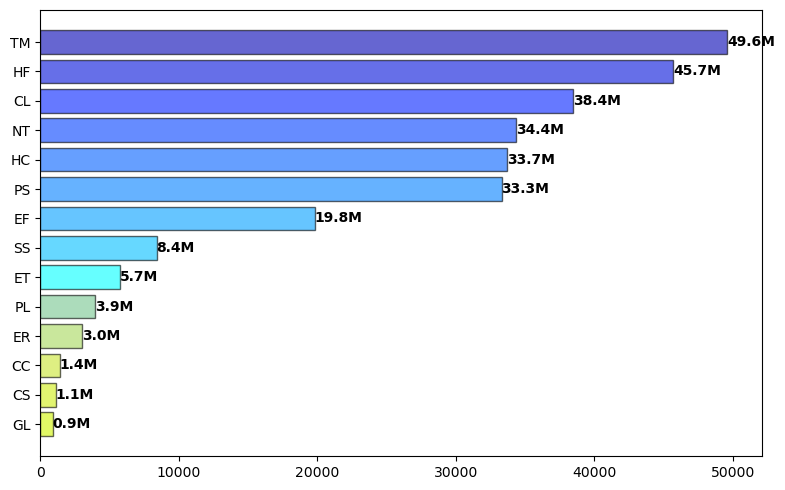

In [36]:
df5 = df4.sum(axis=0).sort_values(ascending=True)      # Series index brands
color_list1 = ["#0000b3", "#0010d9", "#0020ff", "#0040ff", "#0060ff",
               "#0080ff", "#009fff", "#00bfff", "#00ffff", "#76c68f", "#a6d75b", "#c9e52f", "#d0ee11", "#d0f400"]
color_list1_swap = color_list1[::-1]
fig, ax = plt.subplots(figsize=(8, 5))
barh_ytd = ax.barh(df5.index, df5.values, alpha=0.6,
                   color=color_list1_swap, edgecolor='black')    # Index and numpy

for i, val in enumerate(df5):
    ax.text(val, i, 
            str(round(val / 1000, 1)) + 'M',
            ha='left',
            va='center', 
            size=10, 
            weight='bold')

plt.tight_layout()
plt.show()

In [37]:
# Background Gradient
df5 = df4.copy().T / 1000
cm = sns.light_palette("green", as_cmap=True)
df5 = df5.style.background_gradient(cmap=cm, axis=None).format('{:.2f}M')
df5

Period,m01,m02,m03,m04,m05,m06,m07,m08,m09,m10,m11,m12
TM,5.93M,4.76M,6.05M,5.02M,5.95M,5.65M,5.69M,5.13M,5.42M,0.00M,0.00M,0.00M
HF,4.57M,3.74M,5.95M,4.52M,5.63M,5.90M,4.71M,4.97M,5.70M,0.00M,0.00M,0.00M
CL,11.04M,4.74M,6.37M,4.99M,5.28M,2.54M,1.94M,1.05M,0.49M,0.00M,0.00M,0.00M
NT,2.29M,1.39M,4.16M,4.53M,4.21M,3.26M,4.34M,4.47M,5.71M,0.00M,0.00M,0.00M
HC,4.28M,2.92M,3.21M,3.85M,3.52M,3.35M,4.21M,4.61M,3.73M,0.00M,0.00M,0.00M
PS,2.97M,2.34M,3.14M,4.63M,3.47M,2.69M,4.84M,4.86M,4.35M,0.00M,0.00M,0.00M
EF,1.59M,0.52M,2.61M,1.15M,2.25M,4.67M,2.82M,2.17M,2.05M,0.00M,0.00M,0.00M
SS,1.16M,0.74M,0.93M,0.75M,0.78M,0.57M,0.89M,1.51M,1.06M,0.00M,0.00M,0.00M
ET,1.25M,1.24M,1.14M,0.42M,0.38M,0.22M,0.27M,0.49M,0.32M,0.00M,0.00M,0.00M
PL,0.63M,0.37M,0.14M,1.70M,0.12M,0.23M,0.23M,0.34M,0.17M,0.00M,0.00M,0.00M


#### Stack bar amount

C:\Users\aussa\AppData\Local\Temp\ipykernel_36768\699931489.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}M'.format(x) for x in vals / 1000])


<function matplotlib.pyplot.show(close=None, block=None)>

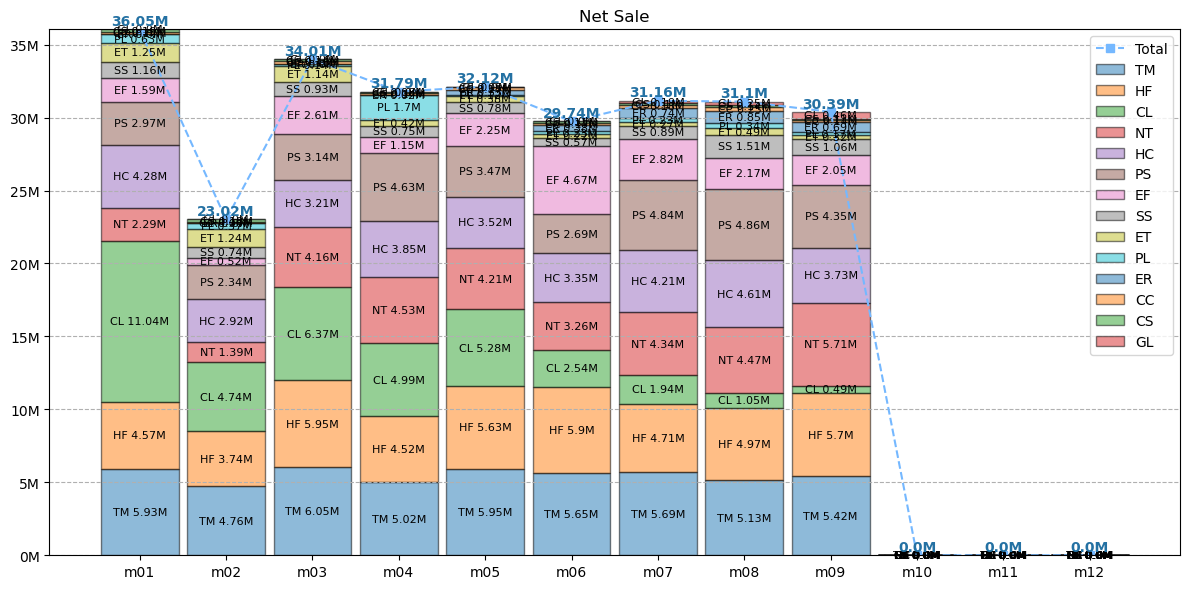

In [38]:
x_period = df4.index
y_total = df4.sum(axis=1)   # series = index period + total values

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(linestyle="--", axis='y')

# stack brands
bottom = np.zeros(len(df4))

for i, col in enumerate(df4.columns):
  ax.bar(x_period, df4[col], bottom=bottom, label=col,
         alpha=0.5, width=0.9, edgecolor='black')
  bottom += np.array(df4[col])

# line total
line_total = ax.plot(x_period, y_total, color='#75B8FF',
                     marker='s', markersize=6, label='Total',  linestyle='--')

# Add labels to each bar.
# stack brands
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df4.cumsum(1)[n], df4[n], df_rel[n])):
        ax.text(i,
                cs - ab / 2,
                n + ' ' + str(np.round(ab / 1000, 2)) + 'M',
                va='center',
                ha='center',
                size=8)

# line total
y_offset = 300
for i, total in enumerate(y_total):
  ax.text(y_total.index[i],
          total + y_offset,
          str(np.round(total / 1000, 2)) + 'M',
          ha='center',
          weight='bold',
          color='#2471A3')

# Format axis-Y
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}M'.format(x) for x in vals / 1000])

ax.set_title(acc_name)
ax.legend()

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

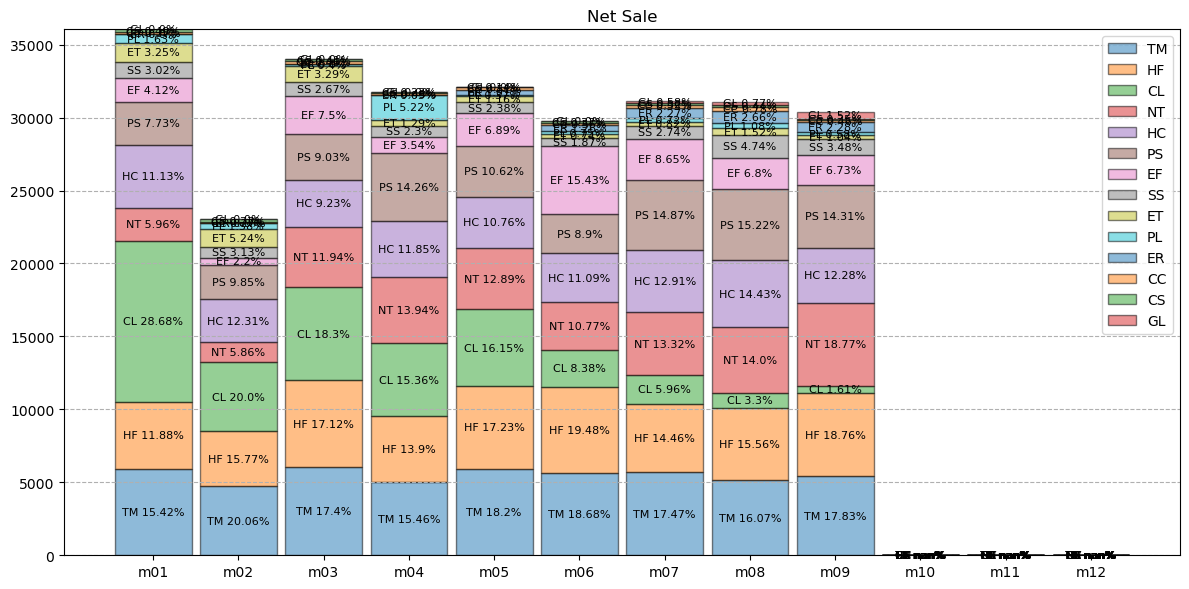

In [39]:
x_period = df4.index

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(linestyle="--", axis='y')

bottom = np.zeros(len(df4))

for i, col in enumerate(df4.columns):
  ax.bar(x_period, df4[col], bottom=bottom, label=col, alpha=0.5, width=0.9, edgecolor='black')
  bottom += np.array(df4[col])

ax.set_title(acc_name)
ax.legend()


for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df4.cumsum(1)[n], df4[n], df_rel[n])):
        ax.text(i,
                cs - ab / 2,
                n + ' ' + str(np.round(pc * 100, 2)) + '%',
                va='center', ha='center',
                size=8)

plt.tight_layout()
plt.show